# Importing the required libraries and packages

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.convolutional import MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, Add, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ReLU, Softmax

from keras.datasets import cifar10

% matplotlib inline

In [0]:
np.random.seed(2017) 

# Loading the data 

In [0]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_test)

170500096/170498071 [==============================] - 2s 0us/step
10000


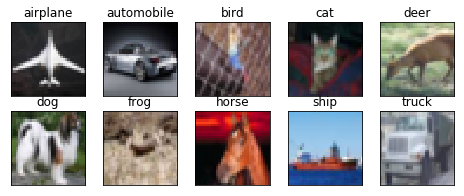

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)

plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model Architecture

Here, I've changed the model from having Dense layers to the actual Convolution layers.

In [0]:
input_data = Input(shape=(32,32,3))

layer1 = SeparableConv2D(32, (3,3), use_bias=False, padding='same')(input_data) # 3rf
layer1 = BatchNormalization()(layer1)
layer1 = ReLU()(layer1)

layer2 = SeparableConv2D(32, (3,3), use_bias=False, padding='same')(layer1) # 5rf
layer2 = BatchNormalization()(layer2)
layer2 = ReLU()(layer2)

layer3 = MaxPooling2D(pool_size=(2,2))(layer2) # 6rf 

layer4_1 = SeparableConv2D(64, (3,3), use_bias=False, padding='same')(layer3)
layer4_1 = BatchNormalization()(layer4_1)
layer4_1 = ReLU()(layer4_1)

layer4_2 = SeparableConv2D(64, (5,5), use_bias=False, padding='same')(layer3)
layer4_2 = BatchNormalization()(layer4_2)
layer4_2 = ReLU()(layer4_2)

layer5_1 = SeparableConv2D(64, (3,3), use_bias=False, padding='same')(layer4_1)
layer5_1 = BatchNormalization()(layer5_1)
layer5_1 = ReLU()(layer5_1)

layer5_2 = SeparableConv2D(64, (5,5), use_bias=False, padding='same')(layer4_2)
layer5_2 = BatchNormalization()(layer5_2)
layer5_2 = ReLU()(layer5_2)

concat_layer = Concatenate()([layer5_1, layer5_2])

layer6 = SeparableConv2D(128, (3,3), use_bias=False, padding='same')(concat_layer)
layer6 = BatchNormalization()(layer6)
layer6 = ReLU()(layer6)

layer7 = SeparableConv2D(128, (3,3), use_bias=False, padding='same')(layer6)
layer7 = BatchNormalization()(layer7)
layer7 = ReLU()(layer7)

layer8 = MaxPooling2D(pool_size=(2,2))(layer7)

layer9 = SeparableConv2D(128, (8,8), use_bias=False)(layer8)

layer10 = Conv2D(10, (1,1), use_bias=False, padding='same')(layer9)

layer11 = Flatten()(layer10)

output = Softmax()(layer11)

In [0]:
model = Model(input=[input_data], output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_9 (SeparableCo (None, 32, 32, 32)   123         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_9[0][0]         
__________________________________________________________________________________________________
re_lu_36 (ReLU)                 (None, 32, 32, 32)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________________
separable_

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, shuffle=False, steps_per_epoch=390, epochs=50)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
390/390 [==============================] - 27s 70ms/step - loss: 1.3173 - acc: 0.5258 - val_loss: 1.2621 - val_acc: 0.5687
Epoch 2/50
390/390 [==============================] - 22s 57ms/step - loss: 0.8982 - acc: 0.6852 - val_loss: 0.9815 - val_acc: 0.6638
Epoch 3/50
390/390 [==============================] - 22s 57ms/step - loss: 0.7536 - acc: 0.7370 - val_loss: 0.9023 - val_acc: 0.6912
Epoch 4/50
390/390 [==============================] - 22s 57ms/step - loss: 0.6667 - acc: 0.7673 - val_loss: 1.0227 - val_acc: 0.6728
Epoch 5/50
390/390 [==============================] - 22s 57ms/step - loss: 0.6004 - acc: 0.7909 - val_loss: 0.8166 - val_acc: 0.7283
Epoch 6/50
390/390 [==============================] - 22s 57ms/step - loss: 0.5427 - acc: 0.8109 - val_loss: 0.7393 - val_acc: 0.7468
Epoch 7/50
390/390 [==============================] - 22s 57ms/step - loss: 0.5009 - acc: 0.8244 - val_loss: 0.9741 - val_acc: 0.6859
Epoch 8/50
390/390 [==============================] - 22s 57ms

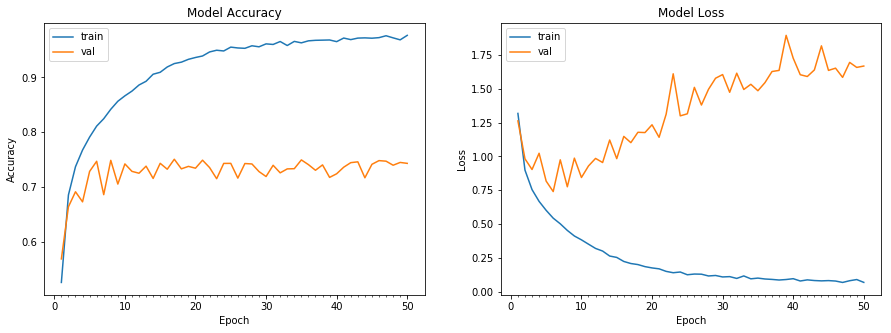

Accuracy on test data is: 74.30


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, shuffle=False)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))